#A MACHINE LEARNING-BASED APPROACH TO CLASSIFY STUDENTS FOR RECRUITMENT (ENSEMBLE LEARNING) (#2)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from imblearn.combine import SMOTETomek
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


#Load Data

In [ ]:
df = pd.read_excel("sample_data/Data Placement.xlsx")
df.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,Branch,Degree,Aptitude,English,Quantitative,Analytical,Domain,Computer Fundamental,Coding,Placement Status
1,Applied Electronics and Instrumentation,B. Tech.,69,87,53,67,30,20,60,Placed
2,Mechanical Engineering,B. Tech.,76,80,73,73,55,40,0,NaN
3,Electronics and Communications Engineering,B. Tech.,71,73,73,67,55,47,20,NaN
4,Applied Electronics and Instrumentation,B. Tech.,71,93,40,80,50,33,20,NaN


#Rename Columns

In [ ]:
#rename columns
df.rename(columns=df.iloc[0], inplace=True)
df.head()

,Branch,Degree,Aptitude,English,Quantitative,Analytical,Domain,Computer Fundamental,Coding,Placement Status
0,Branch,Degree,Aptitude,English,Quantitative,Analytical,Domain,Computer Fundamental,Coding,Placement Status
1,Applied Electronics and Instrumentation,B. Tech.,69,87,53,67,30,20,60,Placed
2,Mechanical Engineering,B. Tech.,76,80,73,73,55,40,0,NaN
3,Electronics and Communications Engineering,B. Tech.,71,73,73,67,55,47,20,NaN
4,Applied Electronics and Instrumentation,B. Tech.,71,93,40,80,50,33,20,NaN


In [ ]:
#drop 0th index
df.drop(index=0, inplace=True)
df.head()

,Branch,Degree,Aptitude,English,Quantitative,Analytical,Domain,Computer Fundamental,Coding,Placement Status
1,Applied Electronics and Instrumentation,B. Tech.,69,87,53,67,30,20,60,Placed
2,Mechanical Engineering,B. Tech.,76,80,73,73,55,40,0,NaN
3,Electronics and Communications Engineering,B. Tech.,71,73,73,67,55,47,20,NaN
4,Applied Electronics and Instrumentation,B. Tech.,71,93,40,80,50,33,20,NaN
5,Electronics and Communications Engineering,B. Tech.,64,73,47,73,55,53,20,NaN


In [ ]:
#reset index
df.reset_index(inplace=True)
df.head()

,index,Branch,Degree,Aptitude,English,Quantitative,Analytical,Domain,Computer Fundamental,Coding,Placement Status
0,1,Applied Electronics and Instrumentation,B. Tech.,69,87,53,67,30,20,60,Placed
1,2,Mechanical Engineering,B. Tech.,76,80,73,73,55,40,0,NaN
2,3,Electronics and Communications Engineering,B. Tech.,71,73,73,67,55,47,20,NaN
3,4,Applied Electronics and Instrumentation,B. Tech.,71,93,40,80,50,33,20,NaN
4,5,Electronics and Communications Engineering,B. Tech.,64,73,47,73,55,53,20,NaN


In [ ]:
#drop 'index' column
df.drop(columns='index', inplace=True)
df.head()

,Branch,Degree,Aptitude,English,Quantitative,Analytical,Domain,Computer Fundamental,Coding,Placement Status
0,Applied Electronics and Instrumentation,B. Tech.,69,87,53,67,30,20,60,Placed
1,Mechanical Engineering,B. Tech.,76,80,73,73,55,40,0,NaN
2,Electronics and Communications Engineering,B. Tech.,71,73,73,67,55,47,20,NaN
3,Applied Electronics and Instrumentation,B. Tech.,71,93,40,80,50,33,20,NaN
4,Electronics and Communications Engineering,B. Tech.,64,73,47,73,55,53,20,NaN


#NaN in Placement Status -> Not Placed

In [ ]:
df['Placement Status'] = df['Placement Status'].fillna('Not Placed')
df.head()

,Branch,Degree,Aptitude,English,Quantitative,Analytical,Domain,Computer Fundamental,Coding,Placement Status
0,Applied Electronics and Instrumentation,B. Tech.,69,87,53,67,30,20,60,Placed
1,Mechanical Engineering,B. Tech.,76,80,73,73,55,40,0,Not Placed
2,Electronics and Communications Engineering,B. Tech.,71,73,73,67,55,47,20,Not Placed
3,Applied Electronics and Instrumentation,B. Tech.,71,93,40,80,50,33,20,Not Placed
4,Electronics and Communications Engineering,B. Tech.,64,73,47,73,55,53,20,Not Placed


#Setting Target in 0/1 Format
##0 -> Positive (or Placed)
##1 -> Negative (or Not Placed)

In [ ]:
df['Placement Status'].replace("Placed", 0, inplace=True)
df['Placement Status'].replace("Not Placed", 1, inplace=True)
df.head()

,Branch,Degree,Aptitude,English,Quantitative,Analytical,Domain,Computer Fundamental,Coding,Placement Status
0,Applied Electronics and Instrumentation,B. Tech.,69,87,53,67,30,20,60,0
1,Mechanical Engineering,B. Tech.,76,80,73,73,55,40,0,1
2,Electronics and Communications Engineering,B. Tech.,71,73,73,67,55,47,20,1
3,Applied Electronics and Instrumentation,B. Tech.,71,93,40,80,50,33,20,1
4,Electronics and Communications Engineering,B. Tech.,64,73,47,73,55,53,20,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12864 entries, 0 to 12863
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Branch                12864 non-null  object
 1   Degree                12864 non-null  object
 2   Aptitude              12864 non-null  object
 3   English               12864 non-null  object
 4   Quantitative          12864 non-null  object
 5   Analytical            12864 non-null  object
 6   Domain                12864 non-null  object
 7   Computer Fundamental  12864 non-null  object
 8   Coding                12864 non-null  object
 9   Placement Status      12864 non-null  int64 
dtypes: int64(1), object(9)
memory usage: 1005.1+ KB


#Data Type Conversion

In [ ]:
df['Aptitude'] = (pd.to_numeric(df['Aptitude'], errors='coerce', downcast='float')).astype('float64')
df['English'] = (pd.to_numeric(df['English'], errors='coerce', downcast='float')).astype('float64')
df['Quantitative'] = (pd.to_numeric(df['Quantitative'], errors='coerce', downcast='float')).astype('float64')
df['Analytical'] = (pd.to_numeric(df['Analytical'], errors='coerce', downcast='float')).astype('float64')
df['Domain'] = (pd.to_numeric(df['Domain'], errors='coerce', downcast='float')).astype('float64')
df['Computer Fundamental'] = (pd.to_numeric(df['Computer Fundamental'], errors='coerce', downcast='float')).astype('float64')
df['Coding'] = (pd.to_numeric(df['Coding'], errors='coerce', downcast='float')).astype('float64')
df.dtypes

Branch                   object
Degree                   object
Aptitude                float64
English                 float64
Quantitative            float64
Analytical              float64
Domain                  float64
Computer Fundamental    float64
Coding                  float64
Placement Status          int64
dtype: object

#Missing Values Treatment

##Finding missing value locations

In [ ]:
df.isnull().sum()

Branch                  0
Degree                  0
Aptitude                1
English                 0
Quantitative            0
Analytical              0
Domain                  0
Computer Fundamental    0
Coding                  0
Placement Status        0
dtype: int64

##Handling missing values

In [ ]:
#imputing mode (based on Placement Status)
def impute_nan(d, variable):
  #Placement Status = 0
  idx_0 = d[d['Placement Status'] == 0].index.tolist() #indexes
  var_0 = d.loc[idx_0, variable] #feature
  var_0_mode = var_0.mode()[0] #mode
  
  #Placement Status = 1
  idx_1 = d[d['Placement Status'] == 1].index.tolist()  #indexes  
  var_1 = d.loc[idx_1, variable] #feature 
  var_1_mode = var_1.mode()[0] #mode

  #NaNs    
  idx_nan = d[d[variable].isnull()].index.tolist() #indexes
  for i in range(len(idx_nan)):
    if d.loc[idx_nan[i], 'Placement Status'] == 0:
      d.loc[idx_nan[i], variable] = var_0_mode
    else:
      d.loc[idx_nan[i], variable] = var_1_mode
  
  return d

In [ ]:
#df.dropna(inplace=True)
df = impute_nan(df, 'Aptitude')
df.isnull().sum()

Branch                  0
Degree                  0
Aptitude                0
English                 0
Quantitative            0
Analytical              0
Domain                  0
Computer Fundamental    0
Coding                  0
Placement Status        0
dtype: int64

#Drop Unwanted Columns

##In this case Branch	& Degree, as Branch	& Degree doesn't play important role in Campus Placement.

In [ ]:
df2 = df.drop(columns=['Branch',	'Degree'])
df2.head()

,Aptitude,English,Quantitative,Analytical,Domain,Computer Fundamental,Coding,Placement Status
0,69.0,87.0,53.0,67.0,30.0,20.0,60.0,0
1,76.0,80.0,73.0,73.0,55.0,40.0,0.0,1
2,71.0,73.0,73.0,67.0,55.0,47.0,20.0,1
3,71.0,93.0,40.0,80.0,50.0,33.0,20.0,1
4,64.0,73.0,47.0,73.0,55.0,53.0,20.0,1


#Count (Positive class and Negative class)

In [ ]:
unique_class, counts_class = np.unique(df['Placement Status'], return_counts=True)
dict(zip(unique_class, counts_class))

{0: 767, 1: 12097}

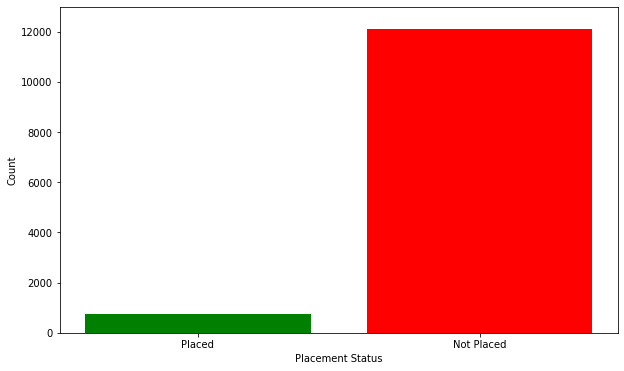

In [ ]:
cY = counts_class.tolist()
cls = unique_class.tolist()
cls_label = []
for c in cls:
  if c == 0:
    cls_label.append('Placed')
  else:
    cls_label.append('Not Placed')

plt.figure(figsize=(10,6))
plt.bar(cls_label, cY, color=['Green', 'Red'])
plt.xlabel("Placement Status")
plt.ylabel('Count')
plt.ylim(0, 13000)
plt.show()

##*Imbalanced data*

#Handling Imbalanced Data - *Over Sampling*

##Separating Features & Labels

In [ ]:
x = df2.drop(columns='Placement Status')
x.head()

,Aptitude,English,Quantitative,Analytical,Domain,Computer Fundamental,Coding
0,69.0,87.0,53.0,67.0,30.0,20.0,60.0
1,76.0,80.0,73.0,73.0,55.0,40.0,0.0
2,71.0,73.0,73.0,67.0,55.0,47.0,20.0
3,71.0,93.0,40.0,80.0,50.0,33.0,20.0
4,64.0,73.0,47.0,73.0,55.0,53.0,20.0


In [ ]:
y = df2['Placement Status']
y.head()

0    0
1    1
2    1
3    1
4    1
Name: Placement Status, dtype: int64

##Oversampling

In [ ]:
smk = SMOTETomek(ratio=1)
x_res, y_res = smk.fit_sample(x, y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
unique_y_res, counts_y_res = np.unique(y_res, return_counts=True)
dict(zip(unique_y_res, counts_y_res))

{0: 12096, 1: 12096}

#Count (Positive class and Negative class)

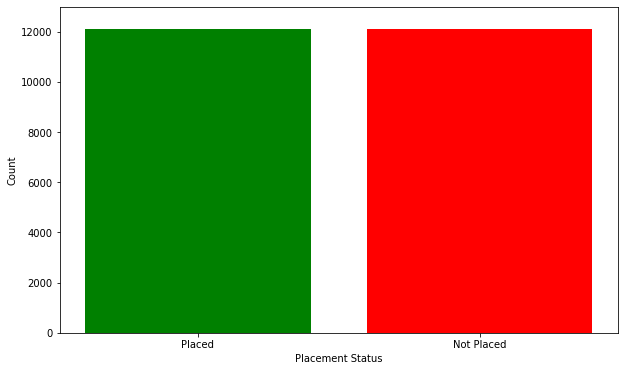

In [ ]:
cY = counts_y_res.tolist()
cls = unique_y_res.tolist()
cls_label = []
for c in cls:
  if c == 0:
    cls_label.append('Placed')
  else:
    cls_label.append('Not Placed')

plt.figure(figsize=(10,6))
plt.bar(cls_label, cY, color=['Green', 'Red'])
plt.xlabel("Placement Status")
plt.ylabel('Count')
plt.ylim(0, 13000)
plt.show()

##*Balanced data*

#Final Features & Labels

In [ ]:
features = pd.DataFrame(x_res, columns=x.columns)
features.head()

,Aptitude,English,Quantitative,Analytical,Domain,Computer Fundamental,Coding
0,69.0,87.0,53.0,67.0,30.0,20.0,60.0
1,76.0,80.0,73.0,73.0,55.0,40.0,0.0
2,71.0,73.0,73.0,67.0,55.0,47.0,20.0
3,71.0,93.0,40.0,80.0,50.0,33.0,20.0
4,64.0,73.0,47.0,73.0,55.0,53.0,20.0


In [ ]:
labels = pd.Series(y_res, name=y.name)
labels.head()

0    0
1    1
2    1
3    1
4    1
Name: Placement Status, dtype: int64

#Train-Test Split

In [ ]:
features_trainval, features_test, labels_trainval, labels_test = train_test_split(features, labels, test_size=0.3, random_state=0)

#Data Pre-processing

In [ ]:
#training-validation data
scaler = MinMaxScaler()
X_trainval = scaler.fit_transform(features_trainval)  #(X - Xmin)/(Xmax - Xmin)
df_X_trainval = pd.DataFrame(data=X_trainval, columns=features.columns)
df_X_trainval.head()

,Aptitude,English,Quantitative,Analytical,Domain,Computer Fundamental,Coding
0,0.737624,0.683170,0.700593,0.499407,0.551313,0.431596,0.0
1,0.763286,0.609305,0.663481,0.671160,0.282795,0.354839,0.0
2,0.523810,0.494737,0.400000,0.470000,0.235294,0.354839,0.0
3,0.714286,0.631579,0.530000,0.670000,0.235294,0.354839,0.2
4,0.583333,0.631579,0.530000,0.330000,0.588235,0.215054,0.0


In [ ]:
#testing data
X_test = scaler.transform(features_test)
df_X_test = pd.DataFrame(data=X_test, columns=features.columns)
df_X_test.head()

,Aptitude,English,Quantitative,Analytical,Domain,Computer Fundamental,Coding
0,0.476190,0.347368,0.400000,0.470000,0.588235,0.139785,0.200000
1,0.357143,0.368421,0.200000,0.350000,0.270588,0.290323,0.000000
2,0.563129,0.578947,0.215143,0.650000,0.317647,0.524915,0.033314
3,0.761905,0.768421,0.670000,0.530000,0.176471,0.215054,0.200000
4,0.780201,0.806169,0.500737,0.699263,0.616924,0.215054,0.000000


In [ ]:
#training-validation data count
Y_trainval = labels_trainval
unique_Y_trainval, counts_Y_trainval = np.unique(Y_trainval, return_counts=True)
dict(zip(unique_Y_trainval, counts_Y_trainval))

{0: 8473, 1: 8461}

In [ ]:
#testing data count
Y_test = labels_test
unique_Y_test, counts_Y_test = np.unique(Y_test, return_counts=True)
dict_Y_test = dict(zip(unique_Y_test, counts_Y_test))
dict_Y_test

{0: 3623, 1: 3635}

#Building models

##Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

###Random Forest

In [ ]:
HP_rf = {'n_estimators':[10,20,30,40,50,60,70,80,90,100]}

tuning_rf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=HP_rf, scoring='accuracy')
tuning_rf.fit(X_trainval, Y_trainval)
tuning_rf.best_params_, tuning_rf.best_score_

({'n_estimators': 90}, 0.9906697736437451)

In [ ]:
clf_rf = RandomForestClassifier(n_estimators=90)

###Ada-Boost

In [ ]:
HP_ab = {'n_estimators':[10,20,30,40,50,60,70,80,90,100], 'learning_rate':[0.01,0.03,0.05,0.1,0.3,0.5]}

tuning_ab = GridSearchCV(estimator=AdaBoostClassifier(), param_grid=HP_ab, scoring='accuracy')
tuning_ab.fit(X_trainval, Y_trainval)
tuning_ab.best_params_, tuning_ab.best_score_

({'learning_rate': 0.5, 'n_estimators': 90}, 0.9172080246367796)

In [ ]:
clf_ab = AdaBoostClassifier(n_estimators=90, learning_rate=0.5)

###Gradient Boost

In [ ]:
HP_gb = {'learning_rate':[0.01,0.03,0.05,0.1,0.3,0.5], 'n_estimators':[10,20,30,40,50,60,70,80,90,100]}

tuning_gb = GridSearchCV(estimator=GradientBoostingClassifier(), param_grid=HP_gb, scoring='accuracy')
tuning_gb.fit(X_trainval, Y_trainval)
tuning_gb.best_params_, tuning_gb.best_score_

({'learning_rate': 0.5, 'n_estimators': 100}, 0.966635502723924)

In [ ]:
clf_gb = GradientBoostingClassifier(learning_rate=0.5, n_estimators=100)

###XGBoost

In [ ]:
HP_xgb = {'eta':[0.01,0.03,0.05,0.1,0.3,0.5], 'gamma':[5,10,15,20,25,30]}

tuning_xgb = GridSearchCV(estimator=XGBClassifier(), param_grid=HP_xgb, scoring='accuracy')
tuning_xgb.fit(X_trainval, Y_trainval)
tuning_xgb.best_params_, tuning_xgb.best_score_

({'eta': 0.01, 'gamma': 5}, 0.9361049361627474)

In [ ]:
clf_xgb = XGBClassifier(eta=0.01, gamma=5)

#StratifiedKFold Cross Validation

In [ ]:
X = np.array(X_trainval)
Y = np.array(Y_trainval)

#training score
train_score_rf = []
train_score_ab = []
train_score_gb = []
train_score_xgb = []
#training time
train_time_rf = []
train_time_ab = []
train_time_gb = []
train_time_xgb = []
#validation accuracy
val_accuracy_rf = []
val_accuracy_ab = []
val_accuracy_gb = []
val_accuracy_xgb = []

skf = StratifiedKFold(n_splits=3)
skf.get_n_splits(X,Y)

for train_index, val_index in skf.split(X, Y):  
  X1_train, X1_val = X[train_index], X[val_index]
  Y1_train, Y1_val = Y[train_index], Y[val_index]

  #training
  #RF    
  st_train_rf = time.time()  #start time
  clf_rf.fit(X1_train, Y1_train)  
  et_train_rf = time.time()  #end time
  train_score_rf.append(clf_rf.score(X1_train, Y1_train))
  train_time_rf.append(et_train_rf - st_train_rf)
  #AB    
  st_train_ab = time.time()  #start time
  clf_ab.fit(X1_train, Y1_train)  
  et_train_ab = time.time()  #end time
  train_score_ab.append(clf_ab.score(X1_train, Y1_train))
  train_time_ab.append(et_train_ab - st_train_ab)
  #GB    
  st_train_gb = time.time()  #start time
  clf_gb.fit(X1_train, Y1_train)  
  et_train_gb = time.time()  #end time
  train_score_gb.append(clf_gb.score(X1_train, Y1_train))
  train_time_gb.append(et_train_gb - st_train_gb)
  #XGB  
  st_train_xgb = time.time()  #start time
  clf_xgb.fit(X1_train, Y1_train)  
  et_train_xgb = time.time()  #end time
  train_score_xgb.append(clf_xgb.score(X1_train, Y1_train))
  train_time_xgb.append(et_train_xgb - st_train_xgb)

  #validation
  #RF  
  prediction_rf = clf_rf.predict(X1_val)      
  val_accuracy_rf.append(accuracy_score(Y1_val, prediction_rf))
  #AB 
  prediction_ab = clf_ab.predict(X1_val)      
  val_accuracy_ab.append(accuracy_score(Y1_val, prediction_ab))
  #GB 
  prediction_gb = clf_gb.predict(X1_val)      
  val_accuracy_gb.append(accuracy_score(Y1_val, prediction_gb))
  #XGB 
  prediction_xgb = clf_xgb.predict(X1_val)      
  val_accuracy_xgb.append(accuracy_score(Y1_val, prediction_xgb))

#training score  
train_score_rf = np.array(train_score_rf)
train_score_ab = np.array(train_score_ab)
train_score_gb = np.array(train_score_gb)
train_score_xgb = np.array(train_score_xgb)
#training time
train_time_rf = np.array(train_time_rf)
train_time_ab = np.array(train_time_ab)
train_time_gb = np.array(train_time_gb)
train_time_xgb = np.array(train_time_xgb)
#validation accuracy
val_accuracy_rf = np.array(val_accuracy_rf)
val_accuracy_ab = np.array(val_accuracy_ab)
val_accuracy_gb = np.array(val_accuracy_gb)
val_accuracy_xgb = np.array(val_accuracy_xgb)

In [ ]:
#RF
train_score_rf.mean(), train_time_rf.mean(), val_accuracy_rf.mean()

(0.9992323145588813, 1.1830610434214275, 0.9882485812577669)

In [ ]:
#AB
train_score_ab.mean(), train_time_ab.mean(), val_accuracy_ab.mean()

(0.9272764458207448, 0.4498864809672038, 0.9236448843359684)

In [ ]:
#GB
train_score_gb.mean(), train_time_gb.mean(), val_accuracy_gb.mean()

(0.9455532992956374, 1.5461761951446533, 0.9404748782029593)

In [ ]:
#XGB
train_score_xgb.mean(), train_time_xgb.mean(), val_accuracy_xgb.mean()

(0.9395594259553791, 0.515803337097168, 0.9374039899503185)

#Testing Phase

In [ ]:
#RF
Y_pred_rf = clf_rf.predict(X_test)
test_score_rf = accuracy_score(Y_test, Y_pred_rf)
test_score_rf

0.9892532378065583

In [ ]:
#AB
Y_pred_ab = clf_ab.predict(X_test)
test_score_ab = accuracy_score(Y_test, Y_pred_ab)
test_score_ab

0.9275282446955084

In [ ]:
#GB
Y_pred_gb = clf_gb.predict(X_test)
test_score_gb = accuracy_score(Y_test, Y_pred_gb)
test_score_gb

0.9384127858914302

In [ ]:
#XGB
Y_pred_xgb = clf_xgb.predict(X_test)
test_score_xgb = accuracy_score(Y_test, Y_pred_xgb)
test_score_xgb

0.93744833287407

#Confusion Matrix

In [ ]:
#RF
conf_mat_rf = confusion_matrix(Y_test, Y_pred_rf)
conf_mat_rf

array([[3612,   11],
       [  67, 3568]])

In [ ]:
#AB
conf_mat_ab = confusion_matrix(Y_test, Y_pred_ab)
conf_mat_ab

array([[3507,  116],
       [ 410, 3225]])

In [ ]:
#GB
conf_mat_gb = confusion_matrix(Y_test, Y_pred_gb)
conf_mat_gb

array([[3498,  125],
       [ 322, 3313]])

In [ ]:
#XGB
conf_mat_xgb = confusion_matrix(Y_test, Y_pred_xgb)
conf_mat_xgb

array([[3535,   88],
       [ 366, 3269]])

#Classification Report

In [ ]:
#RF
classification_report_rf = classification_report(Y_test, Y_pred_rf, target_names=['Placed', 'Not Placed'], output_dict=True)
df_classification_report_rf = pd.DataFrame(classification_report_rf).transpose()
df_classification_report_rf

,precision,recall,f1-score,support
Placed,0.981789,0.996964,0.989318,3623.000000
Not Placed,0.996927,0.981568,0.989188,3635.000000
accuracy,0.989253,0.989253,0.989253,0.989253
macro avg,0.989358,0.989266,0.989253,7258.000000
weighted avg,0.989370,0.989253,0.989253,7258.000000


In [ ]:
#AB
classification_report_ab = classification_report(Y_test, Y_pred_ab, target_names=['Placed', 'Not Placed'], output_dict=True)
df_classification_report_ab = pd.DataFrame(classification_report_ab).transpose()
df_classification_report_ab

,precision,recall,f1-score,support
Placed,0.895328,0.967982,0.930239,3623.000000
Not Placed,0.965280,0.887208,0.924599,3635.000000
accuracy,0.927528,0.927528,0.927528,0.927528
macro avg,0.930304,0.927595,0.927419,7258.000000
weighted avg,0.930362,0.927528,0.927414,7258.000000


In [ ]:
#GB
classification_report_gb = classification_report(Y_test, Y_pred_gb, target_names=['Placed', 'Not Placed'], output_dict=True)
df_classification_report_gb = pd.DataFrame(classification_report_gb).transpose()
df_classification_report_gb

,precision,recall,f1-score,support
Placed,0.915707,0.965498,0.939944,3623.000000
Not Placed,0.963642,0.911417,0.936802,3635.000000
accuracy,0.938413,0.938413,0.938413,0.938413
macro avg,0.939674,0.938457,0.938373,7258.000000
weighted avg,0.939714,0.938413,0.938370,7258.000000


In [ ]:
#XGB
classification_report_xgb = classification_report(Y_test, Y_pred_xgb, target_names=['Placed', 'Not Placed'], output_dict=True)
df_classification_report_xgb = pd.DataFrame(classification_report_xgb).transpose()
df_classification_report_xgb

,precision,recall,f1-score,support
Placed,0.906178,0.975711,0.939660,3623.000000
Not Placed,0.973786,0.899312,0.935069,3635.000000
accuracy,0.937448,0.937448,0.937448,0.937448
macro avg,0.939982,0.937511,0.937364,7258.000000
weighted avg,0.940038,0.937448,0.937360,7258.000000


#Testing with Outside Data

In [ ]:
outside_data = np.array([58, 71, 42,	50,	59,	51, 95])
outside_data = scaler.transform(outside_data.reshape(1, -1)) #data pre-processing

In [ ]:
#RF
clf_rf.predict(outside_data)

array([0])

In [ ]:
#AB
clf_ab.predict(outside_data)

array([0])

In [ ]:
#GB
clf_gb.predict(outside_data)

array([0])

In [ ]:
#XGB
clf_xgb.predict(outside_data)

array([0])

#Model Comparison 
##(Random Forest, Ada-Boost, Gradient Boost, XGBoost)

In [ ]:
model = ['RF', 'AB', 'GB', 'XGB']

##wrt TP, FN, FP, and TN

In [ ]:
tp_fn_fp_tn = np.array([        
                        [conf_mat_rf[0][0], conf_mat_rf[0][1], conf_mat_rf[0][0]+conf_mat_rf[0][1], conf_mat_rf[1][0], conf_mat_rf[1][1], conf_mat_rf[1][0]+conf_mat_rf[1][1]],
                        [conf_mat_ab[0][0], conf_mat_ab[0][1], conf_mat_ab[0][0]+conf_mat_ab[0][1], conf_mat_ab[1][0], conf_mat_ab[1][1], conf_mat_ab[1][0]+conf_mat_ab[1][1]],
                        [conf_mat_gb[0][0], conf_mat_gb[0][1], conf_mat_gb[0][0]+conf_mat_gb[0][1], conf_mat_gb[1][0], conf_mat_gb[1][1], conf_mat_gb[1][0]+conf_mat_gb[1][1]],
                        [conf_mat_xgb[0][0], conf_mat_xgb[0][1], conf_mat_xgb[0][0]+conf_mat_xgb[0][1], conf_mat_xgb[1][0], conf_mat_xgb[1][1], conf_mat_xgb[1][0]+conf_mat_xgb[1][1]]
                        ])
model_tp_fn_fp_tn = pd.DataFrame(data=tp_fn_fp_tn, columns=['TP', 'FN', 'P (Placed)', 'FP', 'TN', 'N (Not Placed)'], index=model)
model_tp_fn_fp_tn

,TP,FN,P (Placed),FP,TN,N (Not Placed)
RF,3612,11,3623,67,3568,3635
AB,3507,116,3623,410,3225,3635
GB,3498,125,3623,322,3313,3635
XGB,3535,88,3623,366,3269,3635


##wrt Precision, Recall, and F1-Score

In [ ]:
precision_recall_f1_score = np.array([
                                      [df_classification_report_rf.loc['Placed', 'precision'], df_classification_report_rf.loc['Not Placed', 'precision'], df_classification_report_rf.loc['Placed', 'recall'], df_classification_report_rf.loc['Not Placed', 'recall'], df_classification_report_rf.loc['Placed', 'f1-score'], df_classification_report_rf.loc['Not Placed', 'f1-score']],
                                      [df_classification_report_ab.loc['Placed', 'precision'], df_classification_report_ab.loc['Not Placed', 'precision'], df_classification_report_ab.loc['Placed', 'recall'], df_classification_report_ab.loc['Not Placed', 'recall'], df_classification_report_ab.loc['Placed', 'f1-score'], df_classification_report_ab.loc['Not Placed', 'f1-score']],
                                      [df_classification_report_gb.loc['Placed', 'precision'], df_classification_report_gb.loc['Not Placed', 'precision'], df_classification_report_gb.loc['Placed', 'recall'], df_classification_report_gb.loc['Not Placed', 'recall'], df_classification_report_gb.loc['Placed', 'f1-score'], df_classification_report_gb.loc['Not Placed', 'f1-score']],
                                      [df_classification_report_xgb.loc['Placed', 'precision'], df_classification_report_xgb.loc['Not Placed', 'precision'], df_classification_report_xgb.loc['Placed', 'recall'], df_classification_report_xgb.loc['Not Placed', 'recall'], df_classification_report_xgb.loc['Placed', 'f1-score'], df_classification_report_xgb.loc['Not Placed', 'f1-score']]
                                      ])
model_precision_recall_f1_score = pd.DataFrame(data=precision_recall_f1_score, columns=['Precision (Placed)', 'Precision (Not Placed)', 'Recall (Placed)', 'Recall (Not Placed)', 'F1-Score (Placed)', 'F1-Score (Not Placed)'], index=model)
model_precision_recall_f1_score

,Precision (Placed),Precision (Not Placed),Recall (Placed),Recall (Not Placed),F1-Score (Placed),F1-Score (Not Placed)
RF,0.981789,0.996927,0.996964,0.981568,0.989318,0.989188
AB,0.895328,0.965280,0.967982,0.887208,0.930239,0.924599
GB,0.915707,0.963642,0.965498,0.911417,0.939944,0.936802
XGB,0.906178,0.973786,0.975711,0.899312,0.939660,0.935069


##wrt Training Score, Validation Accuracy, and Testing Accuracy

In [ ]:
train_val_test_score = np.array([
                                 [train_score_rf.mean(), val_accuracy_rf.mean(), df_classification_report_rf.loc['accuracy', 'support']],
                                 [train_score_ab.mean(), val_accuracy_ab.mean(), df_classification_report_ab.loc['accuracy', 'support']],
                                 [train_score_gb.mean(), val_accuracy_gb.mean(), df_classification_report_gb.loc['accuracy', 'support']],
                                 [train_score_xgb.mean(), val_accuracy_xgb.mean(), df_classification_report_xgb.loc['accuracy', 'support']]
                                 ])
model_train_val_test_score = pd.DataFrame(data=train_val_test_score, columns=['Training Score', 'Validation Accuracy', 'Testing Accuracy'], index=model)
model_train_val_test_score

,Training Score,Validation Accuracy,Testing Accuracy
RF,0.999232,0.988249,0.989253
AB,0.927276,0.923645,0.927528
GB,0.945553,0.940475,0.938413
XGB,0.939559,0.937404,0.937448


##wrt Training Time

In [ ]:
train_time = np.array([
                       [train_time_rf.mean()],
                       [train_time_ab.mean()],
                       [train_time_gb.mean()],
                       [train_time_xgb.mean()]
                       ])
model_train_time = pd.DataFrame(data=train_time, columns=['Training Time'], index=model)
model_train_time

,Training Time
RF,1.183061
AB,0.449886
GB,1.546176
XGB,0.515803


#Model Rankings



##in terms of Testing Accuracy

In [ ]:
#sorting
clf_rank_test = model_train_val_test_score.sort_values(by=['Testing Accuracy'], ascending=False)

#ranking
clf_rank_test['Rank'] = clf_rank_test['Testing Accuracy'].rank(method='max', ascending=False)

#dropping columns
clf_rank_test.drop(columns=['Training Score',	'Validation Accuracy'], inplace=True)

clf_rank_test

,Testing Accuracy,Rank
RF,0.989253,1.0
GB,0.938413,2.0
XGB,0.937448,3.0
AB,0.927528,4.0


##in terms of Training Time

In [ ]:
#sorting
clf_rank_train_time = model_train_time.sort_values(by=['Training Time'])

#ranking
clf_rank_train_time['Rank'] = clf_rank_train_time['Training Time'].rank(method='min')

clf_rank_train_time

,Training Time,Rank
AB,0.449886,1.0
XGB,0.515803,2.0
RF,1.183061,3.0
GB,1.546176,4.0


#Conclusion
##FOCUS: Accuracy
##BEST MODEL: Random Forest


#Saving model to disk

In [ ]:
"""
import pickle

pickle.dump(clf_rf, open('model_rf.pkl','wb'))
pickle.dump(scaler, open('cp_scaler.pkl','wb'))
"""